In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage import measurements
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import math
from collections import deque
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [85]:
from skimage.feature import hog
from sklearn.base import BaseEstimator

class FeatureExtractor(BaseEstimator):
    # class for feature extraction from an image for classification
    def __init__(self, feature_types=['HOG', 'SPAT', 'HIST'],
                 hog_pix_per_cell=8, hog_cell_per_block=2, hog_orient=9,
                hog_params=None,
                color_transform=None, spat_size=(32,32),
                hist_channels=[0], hist_nbins=32, hist_bins_range=(0,256), hog_method='smart'):
        self.feature_types = feature_types
        self.hog_params = hog_params
        self.hog_pix_per_cell = hog_pix_per_cell
        self.hog_cell_per_block = hog_cell_per_block
        self.hog_orient = hog_orient
        self.color_transform = color_transform
        self.spat_size = spat_size
        self.hist_channels = hist_channels
        self.hist_nbins = hist_nbins
        self.hist_bins_range = hist_bins_range
        self.hog_method = hog_method
        
    def fit(self, X, y):
      
        return self
        
    
    def transform(self, X, y=None):
        return self.return_features_all(X)
        
        
    def return_features_all(self, class_imgs):
        class_features = None
        for img in class_imgs:
            features = np.array([], dtype=np.float64)
            for feature_type in self.feature_types:
                features_ = self.return_features(img, feature_type, self.hog_params,
                                                 self.color_transform,
                                                 self.hog_pix_per_cell, self.hog_cell_per_block, self.hog_orient,
                                                 True, False,
                                                 self.spat_size,
                                                 self.hist_channels, self.hist_nbins,
                                                 self.hist_bins_range) # the first element is feature vector anyway
                features=np.concatenate((features, features_.ravel()))
            if class_features is None:
                class_features = features[np.newaxis]
            else:
                class_features = np.vstack([class_features, features[np.newaxis]])
        return class_features
    
    def return_features(self, img, feature_type, hog_params=None, color_transform_flag=None,
                       hog_pix_per_cell=8, hog_cell_per_block=2, hog_orient=9,
                       hog_feature_vec=True, hog_vis=False,
                       spat_size=(32,32),
                       hist_channels=[0], hist_nbins=32, hist_bins_range=(0,256)):
        if feature_type == 'HOG':
            return self.return_hog(img, hog_params=hog_params,
                                  pix_per_cell=hog_pix_per_cell,
                                  cell_per_block=hog_cell_per_block, orient=hog_orient,
                                  feature_vec=hog_feature_vec, vis=hog_vis)
        elif feature_type == 'SPAT':
            return self.return_spat(img, color_transform=color_transform_flag,
                                   size=spat_size)
        elif feature_type == 'HIST':
            hist_features_joint, hist_features, bin_centers = self.return_hist(img, color_transform=color_transform_flag,
                                    channels=hist_channels, nbins=hist_nbins, bins_range=hist_bins_range)
            return hist_features_joint
        else:
            raise ValueError
            
    def return_hog(self, img__, hog_params=None,
                   pix_per_cell=8, cell_per_block=2, orient=9, feature_vec=True, vis=False):
        if hog_params is None:
            img = img__.copy()
        else:
            img = None
            for cmap, channels in hog_params:
                if cmap is None:
                    cimg = img__.copy()
                else:
                    cimg = cv2.cvtColor(img__, cmap)
                for channel in channels:
                    ch = cimg[:,:,channel]
                    ch = ch[:,:,np.newaxis]
                    if img is None:
                        img = ch
                    else:
                        img = np.dstack([img, ch])
        if vis:
            varray = None
        if img.ndim == 2:
            img = img[:,:, np.newaxis]

        hog_joint = None
        
        for i in range(img.shape[-1]):
            return_list = hog(img[...,i], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                              cells_per_block=(cell_per_block, cell_per_block),
                              block_norm= 'L2-Hys', transform_sqrt=False, 
                              visualise= vis, feature_vector= feature_vec)
            if not vis:
                hog_features = return_list
            else:
                hog_features = return_list[0]
            
            if hog_joint is None:
                hog_joint = np.array(hog_features)[np.newaxis]
            else:
                if feature_vec:
                    hog_joint = np.hstack([hog_joint, np.array(hog_features)[np.newaxis]])
                else:
                    hog_joint = np.vstack([hog_joint, hog_features[np.newaxis]])
            
            if vis:
                if varray is None:
                    varray = return_list[1][np.newaxis]
                else:
                    varray = np.vstack(varray, return_list[1][np.newaxis])
        if vis:
            return hog_joint, varray
        else:
            return hog_joint
        
    def return_spat(self, img, color_transform=None, size=(32, 32)):
        if color_transform is None:
            feature_image = img.copy()
        else:
            feature_image = cv2.cvtColor(img, color_transform)           
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(feature_image, size).ravel().astype(np.float64)
        # Return the feature vector
        return np.array([features])
    
    def return_hist(self, img, color_transform=None, channels=[0], nbins=32, bins_range=(0, 256)):
        if color_transform is None:
            feature_image = img.copy()
        else:
            feature_image = cv2.cvtColor(img, color_transform)  
        # take an arbitrary channel for getting bin centers
        rhist = np.histogram(feature_image[:,:,0], bins=nbins, range=bins_range)
        bin_edges = rhist[1]
        bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
        # Concatenate the histograms into a single feature vector
        hist_features = []
        for channel in channels:
            hist, _ = np.histogram(feature_image[:,:,channel], bins=nbins, range=bins_range)
            hist_features.append(hist)
        hist_features = np.array([hist_features])
        hist_features_joint = np.array(hist_features, dtype=np.float64).flatten()
        # Return the individual histograms, bin_centers and feature vector
        return hist_features_joint, hist_features, bin_centers

    def return_sliding_features(self, img, ymin, ymax, xmin, xmax, 
                            init_size=(64,64), scale=1, step=0.125):
        features = None
        for ftype in self.feature_types:
            if ftype == 'HOG':
                ft = self.return_sliding_hog(img, ymin, ymax, xmin, xmax,
                                       init_size=init_size, scale=scale, step=step,
                                    hog_params = self.hog_params,
                                       cell_size=self.hog_pix_per_cell, method=self.hog_method, hog_orient=self.hog_orient)
            elif ftype == 'SPAT':
                ft = self.return_sliding_spat(img, ymin, ymax, xmin, xmax, 
                                         init_size=init_size, scale=scale,
                                         step=step, color_transform=self.color_transform, spat_size=self.spat_size)
            elif ftype == 'HIST':
                ft = self.return_sliding_hist(img, ymin, ymax, xmin, xmax, 
                                         init_size=init_size, scale=scale, step=step,
                                         color_transform=self.color_transform, hist_channels=self.hist_channels,
                                         hist_nbins=self.hist_nbins, hist_bins_range=self.hist_bins_range)
            else:
                raise ValueError
            if features is None:
                features = ft
            else:
                features = np.hstack([features, ft])
        return features
    
    def return_sliding_hog(self, img, ymin, ymax, xmin, xmax, init_size=(64,64), scale=1, step=0.125, cell_size=8,
                           hog_orient = 9,
                             hog_params=None, method='smart'):
        if method == 'smart':
            return self.return_sliding_hog_smart(img, ymin, ymax, xmin, xmax, init_size=init_size,
                                                 scale=scale, step=step, cell_size=cell_size,
                             hog_params=hog_params, hog_orient=hog_orient)
        else:
            return self.return_sliding_hog_simple(img, ymin, ymax, xmin, xmax, init_size=init_size,
                                                 scale=scale, step=step, cell_size=cell_size,
                             hog_params=hog_params)

    def return_sliding_hog_smart(self, img, ymin, ymax, xmin, xmax, init_size=(64,64), scale=1, step=0.125, cell_size=8,
                                 hog_orient = 9,
                             hog_params=None):
        roi = img[ymin:ymax, xmin:xmax, :]
        dy = ymax-ymin
        dx = xmax-xmin
        dy_sc = int(dy/scale)
        dx_sc = int(dx/scale)
        x_init, y_init = init_size
        resized_img = cv2.resize(roi, (dx_sc,dy_sc))
        nsteps_y = math.floor((dy_sc - y_init)/(y_init*step)+1)
        nsteps_x = math.floor((dx_sc - x_init)/(x_init*step)+1)
        delta_index_y = math.floor(step*y_init/cell_size)
        delta_index_x = math.floor(step*x_init/cell_size)
        dy_hog = y_init//cell_size - 1
        dx_hog = x_init//cell_size - 1
        resized_hog = self.return_features(resized_img, 'HOG', hog_params=hog_params, hog_orient = hog_orient,
                                           hog_feature_vec=False)
        window_features = []
        for i in range(nsteps_y):
            y_ind = i*delta_index_y
            for j in range(nsteps_x):
                x_ind = j*delta_index_x
                window_hog = np.array([], dtype=np.float64)
                for channel in range(resized_hog.shape[0]):
                    window_hog_ = resized_hog[channel, y_ind:(y_ind+dy_hog),x_ind:(x_ind+dx_hog),:]
                    window_hog = np.concatenate((window_hog, window_hog_.ravel()))
                window_features.append(window_hog)

        return np.array(window_features) #, np.array(window_imgs)
    
    def return_sliding_hog_simple(self, img, ymin, ymax, xmin, xmax, init_size=(64,64), scale=1, step=0.125, cell_size=8,
                             hog_params=None):
        roi = img[ymin:ymax, xmin:xmax, :]
        dy = ymax-ymin
        dx = xmax-xmin
        dy_sc = int(dy/scale)
        dx_sc = int(dx/scale)
        x_init, y_init = init_size
        resized_img = cv2.resize(roi, (dx_sc,dy_sc))
        nsteps_y = math.floor((dy_sc - y_init)/(y_init*step)+1)
        nsteps_x = math.floor((dx_sc - x_init)/(x_init*step)+1)
        window_features = []
        for i in range(nsteps_y):
            for j in range(nsteps_x):
                window_img = resized_img[int(i*step*y_init):int((i*step+1)*y_init), int(j*step*x_init):int((j*step+1)*x_init), :]
                resized_hog = self.return_features(window_img, 'HOG', hog_params=hog_params, hog_feature_vec=False)
                window_hog = np.array([], dtype=np.float64)
                for channel in range(resized_hog.shape[0]):
                    window_hog_ = resized_hog[channel,...]
                    window_hog = np.concatenate((window_hog, window_hog_.ravel()))
                window_features.append(window_hog)

        return np.array(window_features) #, np.array(window_imgs)

    def return_sliding_spat(self, img, ymin, ymax, xmin, xmax, init_size=(64,64), scale=1,
                            step=0.125, color_transform=None, spat_size=(32,32)):
        roi = img[ymin:ymax, xmin:xmax, :]
        dy = ymax-ymin
        dx = xmax-xmin
        dy_sc = int(dy/scale)
        dx_sc = int(dx/scale)
        x_init, y_init = init_size
        resized_img = cv2.resize(roi, (dx_sc,dy_sc))
        nsteps_y = math.floor((dy_sc - y_init)/(y_init*step)+1)
        nsteps_x = math.floor((dx_sc - x_init)/(x_init*step)+1)
        window_features = []
        for i in range(nsteps_y):
            for j in range(nsteps_x):
                window_img = resized_img[int(i*step*y_init):int((i*step+1)*y_init), int(j*step*x_init):int((j*step+1)*x_init), :]
                features = self.return_features(window_img, 'SPAT',
                                                            color_transform_flag=color_transform, spat_size=spat_size)[0]
                window_features.append(features)
        return np.array(window_features)

    def return_sliding_hist(self, img, ymin, ymax, xmin, xmax, init_size=(64,64), scale=1,
                            step=0.125, color_transform=None,hist_channels=[0], hist_nbins=32, hist_bins_range=(0,256)):
        roi = img[ymin:ymax, xmin:xmax, :]
        dy = ymax-ymin
        dx = xmax-xmin
        dy_sc = int(dy/scale)
        dx_sc = int(dx/scale)
        x_init, y_init = init_size
        resized_img = cv2.resize(roi, (dx_sc,dy_sc))
        nsteps_y = math.floor((dy_sc - y_init)/(y_init*step)+1)
        nsteps_x = math.floor((dx_sc - x_init)/(x_init*step)+1)
        window_features = []
        for i in range(nsteps_y):
            for j in range(nsteps_x):
                window_img = resized_img[int(i*step*y_init):int((i*step+1)*y_init), int(j*step*x_init):int((j*step+1)*x_init), :]
                features = self.return_features(window_img, 'HIST',
                                                            color_transform_flag=color_transform,
                                                            hist_channels=hist_channels, hist_nbins=hist_nbins,
                                                            hist_bins_range=hist_bins_range)
                window_features.append(features)
        return np.array(window_features)
    

In [54]:
class Tracker():
    # class to create and store information of vehicle detections on an image or a series of images
    def __init__(self, classifier, feature_extractor, features_scaler, scale_dict, max_to_keep = 1,
                 heat_threshold=0, single_threshold=None, init_size=(64,64), step=0.125, nms_overlap=0.01,
                cvt_bgr=True, video_mode=True, intersect_threshold=0.9):
        self.clf = classifier
        self.feature_extractor = feature_extractor
        self.scaler = features_scaler
        self.heatmaps = None
        self.max_to_keep = max_to_keep
        self.heat_threshold = heat_threshold
        self.single_threshold = single_threshold
        self.init_size = init_size
        self.step = step
        self.scale_dict = scale_dict
        self.heat_deque = deque([], self.max_to_keep)
        self.bboxes_deque = deque([], self.max_to_keep)
        self.nms_overlap = nms_overlap
        self.cvt_bgr = cvt_bgr
        self.video_mode = video_mode
        self.intersect_threshold = intersect_threshold

        
    def track(self, img_, video_mode=True):
        if self.cvt_bgr:
            img = cv2.cvtColor(img_, cv2.COLOR_RGB2BGR)
        else:
            img = img_.copy()

        himg = img
        heatmaps, _, _ = self.detect_multiscale(himg, self.scale_dict,
                        init_size=self.init_size, step=self.step, return_images=False)
        multiscale_heatmap, _, draw_img = self.draw_multiscale(himg, heatmaps, self.single_threshold)
        
        if video_mode:
            self.heat_deque.append(multiscale_heatmap)
            sum_heat = np.zeros_like(multiscale_heatmap)
            for h in self.heat_deque:
                sum_heat += h
            multiscale_heatmap, _, draw_img = self.draw_multiscale(img, sum_heat, min(max(0,len(self.heat_deque)-1),
                                                                                      self.heat_threshold))
        if self.cvt_bgr:
            draw_img = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
        return draw_img
    
    def track_t(self, img_):
        if self.cvt_bgr:
            img = cv2.cvtColor(img_, cv2.COLOR_RGB2BGR)
        else:
            img = img_.copy()
        himg = img
        multiscale_heatmap, multiscale_bboxes = self.detect_multiscale_t(himg, self.scale_dict,
                        init_size=self.init_size, step=self.step)
        self.heat_deque.append(multiscale_heatmap)
        self.bboxes_deque.append(multiscale_bboxes)
        draw_img = self.draw_multiscale_t(img, self.heat_deque, self.bboxes_deque, self.intersect_threshold, self.video_mode)
        if self.cvt_bgr:
            draw_img = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
        return draw_img
    
    def draw_multiscale_t(self, img, heat_deque, bboxes_deque, thr, video_mode):      
        sum_heatmap = np.zeros((img.shape[0], img.shape[1]))
        bboxes_dict = dict()
        if video_mode:
            for heatmap in heat_deque:
                sum_heatmap += heatmap
            sum_heatmap[sum_heatmap < self.heat_threshold] = 0
            labeled_sum_heatmap, sum_labels = measurements.label(sum_heatmap)

            for i in range(1, sum_labels+1):
                # filter bboxes by their intersect with thresholded heatmap
                masked = np.zeros_like(labeled_sum_heatmap)
                masked[labeled_sum_heatmap==i] = 1
                bboxes_dict[i] = []
                for bboxes in bboxes_deque: # iterate through bboxes deque
                    for bbox in bboxes:
                        x1,y1,x2,y2 = bbox
                        sq = (x2-x1)*(y2-y1)
                        if np.sum(masked[y1:y2,x1:x2]) >= thr*sq:
                            bboxes_dict[i].append(bbox)
                            break # go to next set of bboxes in deque
        else:
            h = heat_deque.pop()
            bboxes = bboxes_deque.pop()
            for i, bbox in enumerate(bboxes):
                bboxes_dict[i+1] = [bbox]
        draw_img = img.copy()
        for k, v in bboxes_dict.items():
            if len(v) > 0:
                x1,y1,x2,y2 = self.get_avg_bbox(v)
                cv2.rectangle(draw_img, (x1,y1), (x2,y2), (0,255,0), 6)
        return draw_img
    
    def get_avg_bbox(self, bboxes_list):
        x1_avg = 0
        x2_avg = 0
        y1_avg = 0
        y2_avg = 0
        n = len(bboxes_list)
        for x1,y1,x2,y2 in bboxes_list:
            x1_avg += x1
            x2_avg += x2
            y1_avg += y1
            y2_avg += y2
        return np.array([x1_avg/n, y1_avg/n, x2_avg/n, y2_avg/n], dtype='int')
               
    def sum_with_threshold(self, heatmaps, threshold):
        sum_heat = np.sum(heatmaps, axis=0)
        sum_heat[sum_heat<=threshold] = 0
        return sum_heat
        
        
    def draw_multiscale(self, img, heatmaps_, threshold=None):
        draw_img = img.copy()
        heatmaps = heatmaps_.copy()
        if threshold is not None:
            heatmaps[heatmaps<=threshold]=0
        ones_heatmap = np.zeros_like(heatmaps)
        ones_heatmap[heatmaps>0] = 1
        labeled_map, labels = measurements.label(ones_heatmap)
        multiscale_heatmap = np.zeros_like(heatmaps)
        multiscale_bboxes = []
        for label_ in range(labels):
            yc, xc, sw = 0, 0, 0
            x_s, y_s = [], []
            selection = labeled_map.copy()
            selection[selection != (label_+1)] = 0
            rows, cols = np.nonzero(selection)
            pts = np.array([rows,cols]).T
            for pt in pts:
                w = heatmaps[pt[0], pt[1]]
                yc += pt[0]*w
                xc += pt[1]*w
                x_s.append(pt[1])
                y_s.append(pt[0])
                sw += w
            yc /= sw
            xc /= sw
            xmin = min(x_s)
            xmax = max(x_s)
            ymin = min(y_s)
            ymax = max(y_s)
            w_2 = min(abs(xmin-xc), abs(xmax-xc))
            h_2 = min(abs(ymin-yc), abs(ymax-yc))
            x1 = int(max(0,xc-w_2))
            x2 = int(min(img.shape[1], xc+w_2))
            y1 = int(max(0, yc-h_2))
            y2 = int(min(img.shape[0], yc+h_2))
            label_bbox = (x1,y1,x2,y2)
            multiscale_heatmap[y1:y2, x1:x2] = 1
            cv2.rectangle(draw_img, (x1,y1), (x2,y2), (0,255,0), 6)
            multiscale_bboxes.append(label_bbox)
        return multiscale_heatmap, multiscale_bboxes, draw_img
        
    def detect_multiscale_t(self, img, scale_dict, init_size, step):
        heatmaps = None
        draw_imgs = None
        bboxes = []
        for k,v in scale_dict.items():
            scale = k
            ymin, ymax, xmin, xmax = v
            heat, bbox, _ = self.detect_cars(img, ymin, ymax, xmin, xmax,
                                               init_size = init_size,
                                               scale = scale, 
                                               step = step)
            if heatmaps is None:
                heatmaps = heat
            else:
                heatmaps += heat
        heatmaps[heatmaps>0] = 1
        labeled_map, labels = measurements.label(heatmaps)
        coms = measurements.center_of_mass(heatmaps, labeled_map, range(1, labels+1))
        coms = np.array(coms, dtype='int')
        for l_, com in enumerate(coms):
            label = l_ + 1
            coords = np.argwhere(labeled_map == label)
            ys = coords[:,0]
            xs = coords[:,1]
            yc, xc = com
            ymin = np.min(ys)
            ymax = np.max(ys)
            xmin = np.min(xs)
            xmax = np.max(xs)
            dy = min(abs(yc-ymin), abs(yc-ymax))
            dx = min(abs(xc-xmin), abs(xc-xmax))
            bboxes.append((xc-dx, yc-dy, xc+dx, yc+dy))
        labeled_map[labeled_map>0] = 1
        
        return labeled_map, bboxes
        
    def detect_multiscale(self, img, scale_dict, init_size, step, return_images=False):
        heatmaps = None
        draw_imgs = None
        bboxes_scaled = []
        for k,v in scale_dict.items():
            scale = k
            ymin, ymax, xmin, xmax = v
            heat, bbox, draw = self.detect_cars(img, ymin, ymax, xmin, xmax,
                                               init_size = init_size,
                                               scale = scale, 
                                               step = step)
            if heatmaps is None:
                heatmaps = heat
            else:
                heatmaps += heat
            if return_images:
                if draw_imgs is None:
                    draw_imgs = draw[np.newaxis]
                else:
                    draw_imgs = np.vstack([draw_imgs, draw[np.newaxis]])
            bboxes_scaled.append((scale,bbox))
        return heatmaps, bboxes_scaled, draw_imgs


    def detect_cars(self, img, ymin, ymax, xmin, xmax,
                    init_size=(64,64), scale=1, step=0.125, color=(0,255,0)):
        features = self.feature_extractor.return_sliding_features(img, ymin, ymax, xmin, xmax,
                                init_size, scale, step)
        scaled_features = self.scaler.transform(features)
        predictions = self.clf.predict(scaled_features)
        heatmap, bboxes, draw_img = self.draw_detections(img, ymin, ymax, xmin, xmax, predictions,
                                                         init_size, scale, step, color=color)
        return heatmap, bboxes, draw_img

    def draw_detections(self, img, ymin, ymax, xmin, xmax, predictions, init_size, scale, step, color=(0,255,0)):
        draw_img = img.copy()
        heatmap = np.zeros((img.shape[0], img.shape[1]))
        dy = ymax-ymin
        dx = xmax-xmin
        dy_sc = int(dy/scale)
        dx_sc = int(dx/scale)
        x_init, y_init = init_size
        nsteps_y = math.floor((dy_sc - y_init)/(y_init*step)+1)
        nsteps_x = math.floor((dx_sc - x_init)/(x_init*step)+1)
        pred = predictions.reshape(nsteps_y, nsteps_x)
        ywin = y_init*scale
        xwin = x_init*scale
        bboxes = []
        for i in range(nsteps_y):
            for j in range(nsteps_x):
                car = pred[i,j]
                if car == 1:
                    x_start = int(xmin+j*x_init*scale*step)
                    x_end = int(x_start + xwin)
                    y_start = int(ymin + i*y_init*scale*step)
                    y_end =int(y_start+ywin)

                    bboxes.append((x_start, y_start, x_end, y_end))
        bboxes = np.array(bboxes, dtype='int')
        nms_bboxes = non_max_suppression_fast(bboxes, self.nms_overlap)
        for bbox in nms_bboxes:
            x_start, y_start, x_end, y_end = bbox
            cv2.rectangle(draw_img, (x_start, y_start), (x_end, y_end), color, 6)
            heatmap[y_start:y_end, x_start:x_end] = 1
        return heatmap, nms_bboxes, draw_img

    

In [20]:
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []

	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")

	# initialize the list of picked indexes	
	pick = []

	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]

	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)

	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)

		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])

		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)

		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]

		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))

	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")

## Make and Observe Data

In [6]:
VEHICLES_PATH = './vehicles/vehicles/'
NONVEHICLES_PATH = './non-vehicles/non-vehicles/'
vehicle_files = [os.path.join(VEHICLES_PATH, x, y) for\
                 x in os.listdir(VEHICLES_PATH) for y in os.listdir(os.path.join(VEHICLES_PATH,x)) if y!='.DS_Store']
nonvehicle_files = [os.path.join(NONVEHICLES_PATH, x, y) for\
                 x in os.listdir(NONVEHICLES_PATH) if x!='.DS_Store'\
                    for y in os.listdir(os.path.join(NONVEHICLES_PATH,x)) if y!='.DS_Store']


X = None
y = np.array([], dtype=np.int)
for vf in vehicle_files:
    img = cv2.imread(vf)
    if X is None:
        X = img[np.newaxis]
    else:
        X = np.vstack([X,img[np.newaxis]])
    y = np.append(y, 1)
for nvf in nonvehicle_files:
    img = cv2.imread(nvf)
    X = np.vstack([X, img[np.newaxis]])
    y = np.append(y,0)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, shuffle=True)

In [8]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(14208, 64, 64, 3)
(3552, 64, 64, 3)
(14208,)
(3552,)


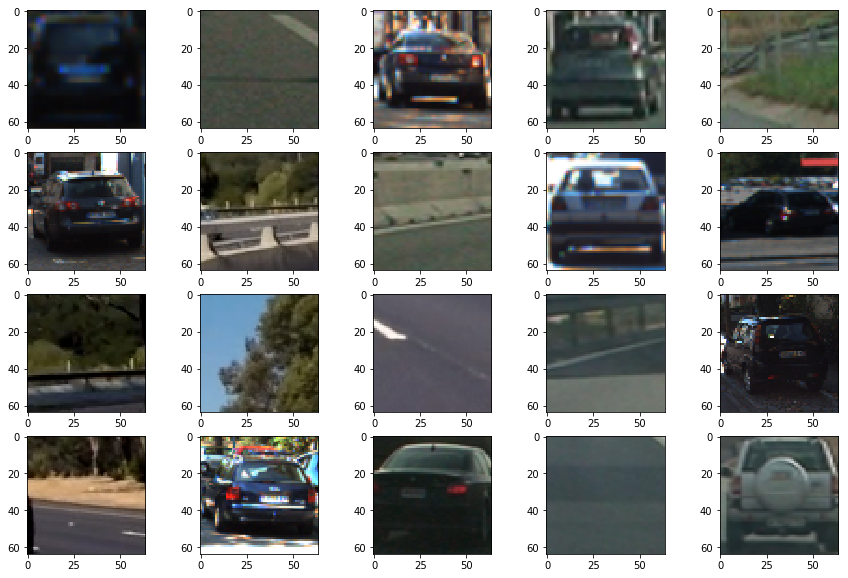

In [74]:
fig = plt.figure(figsize=(15,10))
for i in range(20):
    img = X_train[i]
    fig.add_subplot(4,5,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

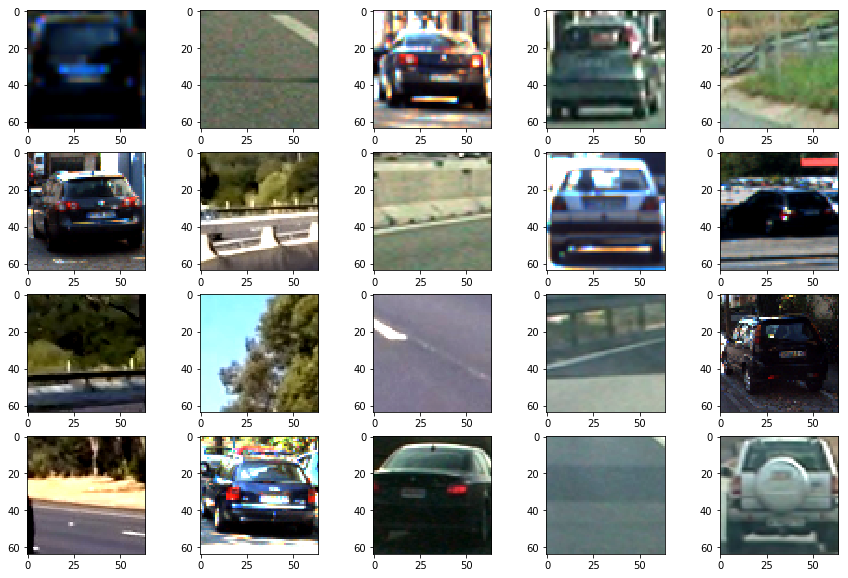

In [83]:
fig = plt.figure(figsize=(15,10))
for i in range(20):
    img = X_train[i]
    img = np.int16(img)  

    contrast   = 100
    brightness = 75

    img = img*(contrast/127 + 1) - contrast + brightness

    # we now have an image that has been adjusted for brightness and
    # contrast, but we need to clip values not in the range 0 to 255
    img = np.clip(img, 0, 255)  # force all values to be between 0 and 255

    # finally, convert image back to unsigned 8 bit integer
    img = np.uint8(img)
    fig.add_subplot(4,5,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()


In [9]:
data = dict()
data['X_train'] = X_train
data['X_test'] = X_test
data['y_train'] = y_train
data['y_test'] = y_test

In [11]:
'''import pickle
pth = './data/train_data_X_y'
if not os.path.exists(pth):
    os.mkdir(pth)

with open(os.path.join(pth, 'data.p'), 'wb') as f:
    pickle.dump(data,f)
'''

In [5]:
pth = './data/train_data_X_y'
with open(os.path.join(pth, 'data.p'), 'rb') as f:
    data=pickle.load(f)
    
X_train = data['X_train']
X_test = data['X_test'] 
y_train = data['y_train']
y_test = data['y_test']

print(X_train.shape, X_test.shape)

(14208, 64, 64, 3) (3552, 64, 64, 3)


#### Adding hard negative

In [6]:
hard_path = './hard_negatives'
hard_files = [os.path.join(hard_path, x) for x in os.listdir(hard_path) if x.endswith('.jpg')]
X = None
y = np.array([], dtype=np.int)

for nvf in hard_files:
    img = cv2.imread(nvf)
    if X is None:
        X = img[np.newaxis]
    else:
        X = np.vstack([X, img[np.newaxis]])
    y = np.append(y,0)
    
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X, y, test_size=0.2, random_state=123, shuffle=True)
X_train_e = np.vstack([X_train, X_train_h])
X_test_e = np.vstack([X_test, X_test_h])
y_train_e = np.append(y_train, y_train_h)
y_test_e = np.append(y_test, y_test_h)

In [7]:
X_train_e.shape

(15808, 64, 64, 3)

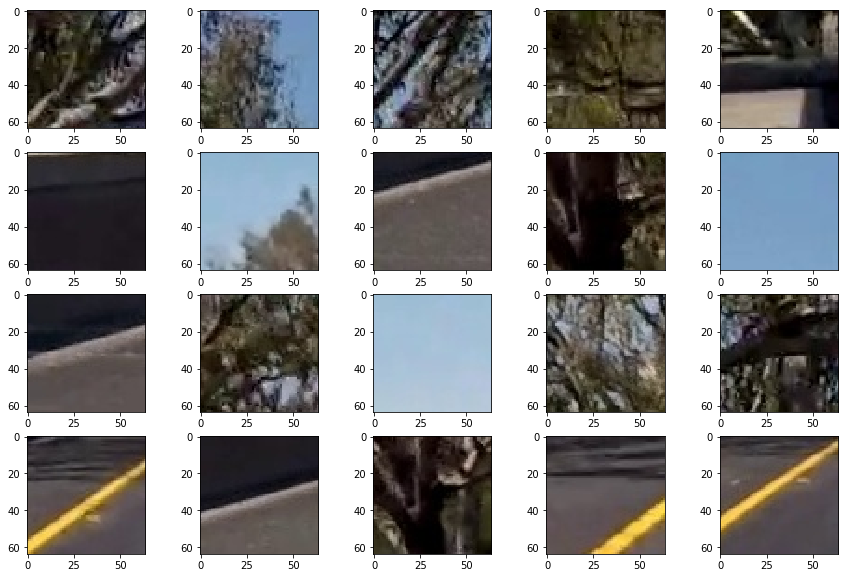

In [8]:
fig = plt.figure(figsize=(15,10))
for i in range(20):
    img = X_train_h[i]
    fig.add_subplot(4,5,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

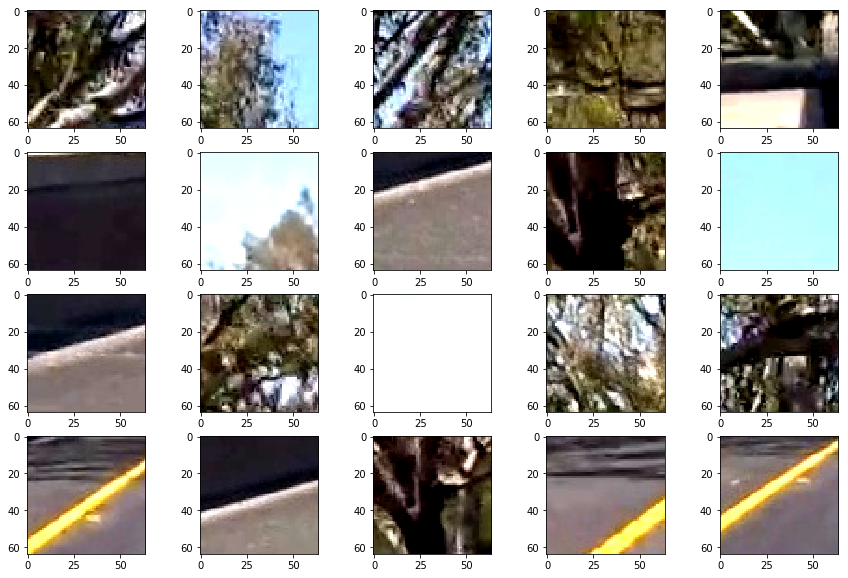

In [9]:
fig = plt.figure(figsize=(15,10))
for i in range(20):
    img = X_train_h[i]
    img = np.int16(img)  

    contrast   = 100
    brightness = 75

    img = img*(contrast/127 + 1) - contrast + brightness

    # we now have an image that has been adjusted for brightness and
    # contrast, but we need to clip values not in the range 0 to 255
    img = np.clip(img, 0, 255)  # force all values to be between 0 and 255

    # finally, convert image back to unsigned 8 bit integer
    img = np.uint8(img)
    fig.add_subplot(4,5,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

## Pipeline implementation

In [61]:
feature_extractor = FeatureExtractor()
classifier = RandomForestClassifier(n_estimators=100)
scaler = StandardScaler()
pipeline = Pipeline([('fextr', feature_extractor),('scl', scaler), ('clf', classifier)])
kf = KFold(n_splits=3)
param_grid = {'fextr__feature_types':[['HOG', 'SPAT', 'HIST'], ['HOG', 'HIST']], 
             'fextr__hog_params': [[(cv2.COLOR_BGR2YCrCb,[0])],
                                   [(cv2.COLOR_BGR2RGB,[0])],
                                   [(cv2.COLOR_BGR2HLS,[0])],
                                   [(cv2.COLOR_BGR2RGB,[0,2])],
                                   [(cv2.COLOR_BGR2RGB,[0,1,2])]
                                  ],
             'fextr__color_transform': [cv2.COLOR_BGR2RGB, cv2.COLOR_BGR2HLS, cv2.COLOR_BGR2YCrCb],
             'fextr__hist_channels':[[0,1,2]],
             'fextr__hist_nbins':[32,64],
             'fextr__hist_bins_range':[(0,256)],
             'fextr__spat_size':[(16,16),(32,32)],
              'fextr__hog_orient':[8,9,10,11],
              'fextr__hog_pix_per_cell':[8],
             'clf__criterion':['gini', 'entropy'],
             }
scorer = make_scorer(f1_score)
clf = RandomizedSearchCV(pipeline, param_grid, n_iter=32, cv=kf, scoring=scorer, verbose=2, n_jobs=15)
clf.fit(X_train_e, y_train_e)
best_p_final = clf.best_estimator_
results = clf.cv_results_

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] fextr__spat_size=(16, 16), fextr__hog_pix_per_cell=8, fextr__hog_params=[(4, [0, 2])], fextr__hog_orient=10, fextr__hist_nbins=32, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'HIST'], fextr__color_transform=4, clf__criterion=entropy 
[CV] fextr__spat_size=(16, 16), fextr__hog_pix_per_cell=8, fextr__hog_params=[(4, [0, 2])], fextr__hog_orient=10, fextr__hist_nbins=32, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'HIST'], fextr__color_transform=4, clf__criterion=entropy 
[CV] fextr__spat_size=(16, 16), fextr__hog_pix_per_cell=8, fextr__hog_params=[(4, [0, 2])], fextr__hog_orient=10, fextr__hist_nbins=32, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'HIST'], fextr__color_transform=4, clf__criterion=entropy 
[CV] fextr__spat_size=(16, 16), fextr__hog_pix_per_cell=8, fextr__hog_pa

[CV] fextr__spat_size=(16, 16), fextr__hog_pix_per_cell=8, fextr__hog_params=[(4, [0, 2])], fextr__hog_orient=10, fextr__hist_nbins=32, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'SPAT', 'HIST'], fextr__color_transform=52, clf__criterion=gini 
[CV]  fextr__spat_size=(16, 16), fextr__hog_pix_per_cell=8, fextr__hog_params=[(4, [0])], fextr__hog_orient=10, fextr__hist_nbins=32, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'SPAT', 'HIST'], fextr__color_transform=36, clf__criterion=gini, total=30.5min
[CV] fextr__spat_size=(16, 16), fextr__hog_pix_per_cell=8, fextr__hog_params=[(4, [0, 2])], fextr__hog_orient=10, fextr__hist_nbins=32, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'SPAT', 'HIST'], fextr__color_transform=52, clf__criterion=gini 
[CV]  fextr__spat_size=(16, 16), fextr__hog_pix_per_cell=8, fextr__hog_params=[(4, [0])], fextr__hog_or

[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed: 78.5min


[CV]  fextr__spat_size=(32, 32), fextr__hog_pix_per_cell=8, fextr__hog_params=[(4, [0, 2])], fextr__hog_orient=10, fextr__hist_nbins=64, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'HIST'], fextr__color_transform=52, clf__criterion=gini, total=45.6min
[CV] fextr__spat_size=(32, 32), fextr__hog_pix_per_cell=8, fextr__hog_params=[(4, [0, 2])], fextr__hog_orient=8, fextr__hist_nbins=32, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'HIST'], fextr__color_transform=4, clf__criterion=entropy 
[CV]  fextr__spat_size=(16, 16), fextr__hog_pix_per_cell=8, fextr__hog_params=[(4, [0, 2])], fextr__hog_orient=10, fextr__hist_nbins=32, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'HIST'], fextr__color_transform=4, clf__criterion=entropy, total=47.9min
[CV] fextr__spat_size=(16, 16), fextr__hog_pix_per_cell=8, fextr__hog_params=[(36, [0])], fextr__hog_orien

[CV]  fextr__spat_size=(32, 32), fextr__hog_pix_per_cell=8, fextr__hog_params=[(4, [0, 2])], fextr__hog_orient=8, fextr__hist_nbins=32, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'HIST'], fextr__color_transform=4, clf__criterion=entropy, total=43.6min
[CV] fextr__spat_size=(32, 32), fextr__hog_pix_per_cell=8, fextr__hog_params=[(36, [0])], fextr__hog_orient=10, fextr__hist_nbins=32, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'SPAT', 'HIST'], fextr__color_transform=4, clf__criterion=entropy 
[CV]  fextr__spat_size=(32, 32), fextr__hog_pix_per_cell=8, fextr__hog_params=[(4, [0, 2])], fextr__hog_orient=8, fextr__hist_nbins=32, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'HIST'], fextr__color_transform=4, clf__criterion=entropy, total=43.0min
[CV] fextr__spat_size=(32, 32), fextr__hog_pix_per_cell=8, fextr__hog_params=[(36, [0])], fextr__ho

[CV]  fextr__spat_size=(32, 32), fextr__hog_pix_per_cell=8, fextr__hog_params=[(36, [0])], fextr__hog_orient=10, fextr__hist_nbins=32, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'SPAT', 'HIST'], fextr__color_transform=4, clf__criterion=entropy, total=45.7min
[CV] fextr__spat_size=(16, 16), fextr__hog_pix_per_cell=8, fextr__hog_params=[(4, [0, 1, 2])], fextr__hog_orient=11, fextr__hist_nbins=64, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'SPAT', 'HIST'], fextr__color_transform=4, clf__criterion=entropy 
[CV]  fextr__spat_size=(32, 32), fextr__hog_pix_per_cell=8, fextr__hog_params=[(36, [0])], fextr__hog_orient=10, fextr__hist_nbins=32, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'SPAT', 'HIST'], fextr__color_transform=4, clf__criterion=entropy, total=47.9min
[CV] fextr__spat_size=(16, 16), fextr__hog_pix_per_cell=8, fextr__hog_params=[(4

[CV]  fextr__spat_size=(32, 32), fextr__hog_pix_per_cell=8, fextr__hog_params=[(4, [0, 2])], fextr__hog_orient=8, fextr__hist_nbins=32, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'SPAT', 'HIST'], fextr__color_transform=36, clf__criterion=entropy, total=61.2min
[CV] fextr__spat_size=(16, 16), fextr__hog_pix_per_cell=8, fextr__hog_params=[(36, [0])], fextr__hog_orient=11, fextr__hist_nbins=32, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'HIST'], fextr__color_transform=52, clf__criterion=entropy 
[CV]  fextr__spat_size=(32, 32), fextr__hog_pix_per_cell=8, fextr__hog_params=[(4, [0, 2])], fextr__hog_orient=8, fextr__hist_nbins=32, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'SPAT', 'HIST'], fextr__color_transform=36, clf__criterion=entropy, total=60.7min
[CV] fextr__spat_size=(32, 32), fextr__hog_pix_per_cell=8, fextr__hog_params=[(4, [0])],

[CV]  fextr__spat_size=(16, 16), fextr__hog_pix_per_cell=8, fextr__hog_params=[(4, [0, 1, 2])], fextr__hog_orient=11, fextr__hist_nbins=64, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'SPAT', 'HIST'], fextr__color_transform=4, clf__criterion=entropy, total=80.5min
[CV] fextr__spat_size=(32, 32), fextr__hog_pix_per_cell=8, fextr__hog_params=[(36, [0])], fextr__hog_orient=11, fextr__hist_nbins=64, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'HIST'], fextr__color_transform=52, clf__criterion=entropy 
[CV]  fextr__spat_size=(16, 16), fextr__hog_pix_per_cell=8, fextr__hog_params=[(4, [0, 1, 2])], fextr__hog_orient=11, fextr__hist_nbins=64, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'SPAT', 'HIST'], fextr__color_transform=4, clf__criterion=entropy, total=81.3min
[CV] fextr__spat_size=(32, 32), fextr__hog_pix_per_cell=8, fextr__hog_params=[(36,

[CV]  fextr__spat_size=(32, 32), fextr__hog_pix_per_cell=8, fextr__hog_params=[(4, [0])], fextr__hog_orient=9, fextr__hist_nbins=32, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'SPAT', 'HIST'], fextr__color_transform=4, clf__criterion=gini, total=42.7min
[CV]  fextr__spat_size=(32, 32), fextr__hog_pix_per_cell=8, fextr__hog_params=[(4, [0])], fextr__hog_orient=9, fextr__hist_nbins=32, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'SPAT', 'HIST'], fextr__color_transform=4, clf__criterion=gini, total=44.0min
[CV]  fextr__spat_size=(32, 32), fextr__hog_pix_per_cell=8, fextr__hog_params=[(4, [0])], fextr__hog_orient=9, fextr__hist_nbins=32, fextr__hist_channels=[0, 1, 2], fextr__hist_bins_range=(0, 256), fextr__feature_types=['HOG', 'SPAT', 'HIST'], fextr__color_transform=4, clf__criterion=gini, total=44.6min
[CV]  fextr__spat_size=(32, 32), fextr__hog_pix_per_cell=8, fextr__hog_params=[(36, [

[Parallel(n_jobs=15)]: Done  96 out of  96 | elapsed: 445.6min finished


In [45]:
best_p_final

Pipeline(memory=None,
     steps=[('fextr', FeatureExtractor(brightness=100, color_transform=36, contrast=0,
         feature_types=['HOG', 'HIST'], hist_bins_range=(0, 256),
         hist_channels=[0, 1, 2], hist_nbins=32, hog_cell_per_block=2,
         hog_method='smart', hog_orient=8, hog_params=[(4, [0, 2])],
         hog...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [95]:
import pandas as pd
pd.DataFrame(results).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_fextr__spat_size,param_fextr__hog_pix_per_cell,param_fextr__hog_params,param_fextr__hog_orient,param_fextr__hist_nbins,param_fextr__hist_channels,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
28,1766.165648,9.079551,352.790801,2.360733,"(16, 16)",8,"[(4, [0])]",11,64,"[0, 1, 2]",...,0.990513,0.988831,0.989847,0.000730,1,1.0,1.0,1.0,1.0,0.0
30,1149.694146,21.638318,247.243269,3.983270,"(16, 16)",8,"[(36, [0])]",8,64,"[0, 1, 2]",...,0.990122,0.991799,0.989767,0.001821,2,1.0,1.0,1.0,1.0,0.0
9,1252.107230,22.179082,337.877047,19.973947,"(16, 16)",8,"[(36, [0])]",8,64,"[0, 1, 2]",...,0.990321,0.984807,0.988506,0.002616,3,1.0,1.0,1.0,1.0,0.0
4,1530.976290,7.493155,307.065623,2.774197,"(16, 16)",8,"[(4, [0])]",10,32,"[0, 1, 2]",...,0.989731,0.984015,0.987981,0.002810,4,1.0,1.0,1.0,1.0,0.0
17,2850.043575,38.275871,801.004622,29.468337,"(32, 32)",8,"[(4, [0, 2])]",8,32,"[0, 1, 2]",...,0.987788,0.981622,0.986536,0.003611,5,1.0,1.0,1.0,1.0,0.0


In [70]:
fx = best_p_final.named_steps['fextr']
cl = best_p_final.named_steps['clf']
scl = best_p_final.named_steps['scl']

In [71]:
fx

FeatureExtractor(brightness=0, color_transform=36, contrast=0,
         feature_types=['HOG', 'SPAT', 'HIST'], hist_bins_range=(0, 256),
         hist_channels=[0, 1, 2], hist_nbins=64, hog_cell_per_block=2,
         hog_method='smart', hog_orient=11, hog_params=[(4, [0])],
         hog_pix_per_cell=8, spat_size=(16, 16))

In [72]:
cl

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [73]:
scl

StandardScaler(copy=True, with_mean=True, with_std=True)

#### Testing results

In [74]:
X_features_test = fx.transform(X_test_e)
X_features_scaled = scl.transform(X_features_test)
preds = cl.predict(X_features_scaled)
print(accuracy_score(y_test_e, preds))

0.9929167720718441


In [75]:

trans = dict()
trans['feature_extractor'] = fx
trans['classifier'] = cl
trans['scaler'] = scl
with open('./data/train_data_X_y/transformers_final_f1.p', 'wb') as f:
    pickle.dump(trans, f)


In [ ]:
'''
with open('./data/train_data_X_y/transformers_final_f1.p', 'rb') as f:
    trans = pickle.load(f)
fx=trans['feature_extractor']
cl=trans['classifier']
scl=trans['scaler']
'''

In [86]:
fextr = FeatureExtractor(color_transform=36,
         feature_types=['HOG', 'SPAT', 'HIST'], hist_bins_range=(0, 256),
         hist_channels=[0, 1, 2], hist_nbins=64, hog_cell_per_block=2,
         hog_method='smart', hog_orient=11, hog_params=[(4, [0])],
         hog_pix_per_cell=8, spat_size=(16, 16))
tracker = Tracker(cl, fextr, scl,
                  scale_dict={1:(360,550,300,1280), 1.5:(360,550,300,1280), 2:(360,550,300,1280)}, max_to_keep = 8,
                 heat_threshold=3, single_threshold=1, init_size=(64,64), step=0.125, nms_overlap=0.1)

output = './output_videos/project_video_sub_20_40_tracker_t.mp4'
img_processor = tracker.track_t

clip1 = VideoFileClip("./project_video.mp4").subclip(20,40)
clip = clip1.fl_image(img_processor)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./output_videos/project_video_sub_20_40_tracker_t.mp4
[MoviePy] Writing video ./output_videos/project_video_sub_20_40_tracker_t.mp4


100%|█████████▉| 500/501 [17:57<00:02,  2.16s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video_sub_20_40_tracker_t.mp4 

CPU times: user 57min 33s, sys: 3min 22s, total: 1h 56s
Wall time: 17min 58s


In [87]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [92]:
fextr = FeatureExtractor(color_transform=36,
         feature_types=['HOG', 'SPAT', 'HIST'], hist_bins_range=(0, 256),
         hist_channels=[0, 1, 2], hist_nbins=64, hog_cell_per_block=2,
         hog_method='smart', hog_orient=11, hog_params=[(4, [0])],
         hog_pix_per_cell=8, spat_size=(16, 16))
tracker = Tracker(cl, fextr, scl,
                  scale_dict={1:(360,550,300,1280), 1.5:(360,550,300,1280), 2:(360,550,300,1280)}, max_to_keep = 8,
                 heat_threshold=4, single_threshold=1, init_size=(64,64), step=0.125, nms_overlap=0.1)

output2 = './output_videos/project_video_sub_20_40_tracker.mp4'
img_processor = tracker.track

clip1 = VideoFileClip("./project_video.mp4").subclip(20,40)
clip = clip1.fl_image(img_processor)
%time clip.write_videofile(output2, audio=False)

[MoviePy] >>>> Building video ./output_videos/project_video_sub_20_40_tracker.mp4
[MoviePy] Writing video ./output_videos/project_video_sub_20_40_tracker.mp4


100%|█████████▉| 500/501 [19:33<00:02,  2.35s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video_sub_20_40_tracker.mp4 

CPU times: user 1h 4min 23s, sys: 3min 46s, total: 1h 8min 9s
Wall time: 19min 34s


In [93]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output2))

In [94]:
fextr = FeatureExtractor(color_transform=36,
         feature_types=['HOG', 'SPAT', 'HIST'], hist_bins_range=(0, 256),
         hist_channels=[0, 1, 2], hist_nbins=64, hog_cell_per_block=2,
         hog_method='smart', hog_orient=11, hog_params=[(4, [0])],
         hog_pix_per_cell=8, spat_size=(16, 16))
tracker = Tracker(cl, fextr, scl,
                  scale_dict={1:(360,550,300,1280), 1.5:(360,550,300,1280), 2:(360,550,300,1280)}, max_to_keep = 8,
                 heat_threshold=4, single_threshold=1, init_size=(64,64), step=0.125, nms_overlap=0.1)

output3 = './output_videos/project_video_tracker.mp4'
img_processor = tracker.track

clip1 = VideoFileClip("./project_video.mp4")
clip = clip1.fl_image(img_processor)
%time clip.write_videofile(output3, audio=False)

[MoviePy] >>>> Building video ./output_videos/project_video_tracker.mp4
[MoviePy] Writing video ./output_videos/project_video_tracker.mp4


100%|█████████▉| 1260/1261 [49:09<00:02,  2.34s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video_tracker.mp4 

CPU times: user 2h 41min 31s, sys: 9min 36s, total: 2h 51min 8s
Wall time: 49min 9s


In [96]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output3))